# Training and evaluation notebook
Round 5 no. 9 binary classification based on class 3 (bare peat) and class 4 (restored) from the original dataset, and trained on bands only

In [10]:
## imports
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

## 1. Construct dataset

In [11]:
merged_df = pd.read_csv('merged_df.csv')
merged_df


,Unnamed: 0,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,classes,NDVI,EVI,NDWI,SAVI,GNDVI
0,0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2,0.568914,0.246737,-0.052386,0.271183,0.670018
1,1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2,0.581259,0.287926,-0.015721,0.308070,0.688819
2,2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2,0.834221,0.731688,0.337125,0.652436,0.765506
3,3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2,0.776236,0.581962,0.247564,0.544852,0.721622
4,4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2,0.830017,0.746039,0.372872,0.664865,0.767403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152805,1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2,0.516930,0.319632,-0.031002,0.321629,0.602862
1152806,1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2,0.625819,0.443384,0.076328,0.432730,0.637691
1152807,1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2,0.484021,0.294097,-0.044519,0.296020,0.571209
1152808,1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2,0.602697,0.397850,0.009969,0.393631,0.653291


In [12]:
# renaming 'class' column to 'classes' to fix python error
merged_df = merged_df.rename(columns={'class': 'classes'})

In the following, I will make some new dataframes for binary classification:

In [13]:
# Step 4: Create a DataFrame with classes 3 and 4
class_3_4_df = merged_df[merged_df['classes'].isin([3, 4])]

# Remember to reset the index if needed, for example:
# binary_df = binary_df.reset_index(drop=True)

# Note: Using .loc for assignment avoids SettingWithCopyWarning.

Dropping columns:

In [14]:
# Select only the columns you want to keep
class_3_4_df = class_3_4_df.loc[:, ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
                              'B9', 'B11', 'B12', 'classes']]
class_3_4_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,classes
35750,0.02970,0.02580,0.04230,0.07455,0.09715,0.11690,0.14080,0.15460,0.18725,0.18210,0.30790,0.23750,3
35751,0.01420,0.01870,0.02390,0.04320,0.05080,0.06020,0.07470,0.09140,0.10240,0.10710,0.31970,0.25230,3
35752,0.02725,0.02280,0.03020,0.05910,0.07400,0.08120,0.10220,0.11940,0.14680,0.14200,0.35250,0.26460,3
35753,0.02280,0.02395,0.03355,0.05455,0.06725,0.08180,0.10450,0.13280,0.14380,0.13440,0.35790,0.28405,3
35754,0.02380,0.02480,0.03590,0.06600,0.08410,0.09725,0.12025,0.14195,0.15835,0.15760,0.28895,0.21005,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
973048,0.04320,0.07920,0.10860,0.10840,0.14960,0.24210,0.26960,0.27300,0.30400,0.33030,0.26350,0.17790,4
973049,0.03785,0.04785,0.06970,0.06560,0.12645,0.25330,0.29020,0.29550,0.32395,0.36635,0.25945,0.14200,4
973050,0.03790,0.04110,0.06890,0.06720,0.13390,0.26230,0.30250,0.31360,0.32760,0.34050,0.25300,0.14900,4
973051,0.04520,0.03395,0.05660,0.04715,0.10640,0.22845,0.26085,0.28060,0.29645,0.29380,0.21370,0.11775,4


## Constructing train and test sets

Shuffling dataset first:



In [15]:
# Shuffle the DataFrame using a random seed, for example, seed=42
class_3_4_df = class_3_4_df.sample(frac=1, random_state=42).reset_index(drop=True)
class_3_4_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,classes
0,0.0495,0.07330,0.0938,0.08920,0.1599,0.21980,0.24960,0.2828,0.29300,0.31260,0.2495,0.12940,4
1,0.0353,0.04500,0.0728,0.06720,0.1296,0.28760,0.33790,0.3388,0.38820,0.34330,0.2761,0.14260,4
2,0.0340,0.05010,0.0746,0.10120,0.1503,0.21470,0.24200,0.2878,0.29580,0.31110,0.2949,0.17330,4
3,0.0494,0.05465,0.0758,0.08235,0.1313,0.21885,0.24865,0.2826,0.29130,0.28510,0.2600,0.15555,4
4,0.0207,0.02440,0.0330,0.05660,0.0755,0.08740,0.10810,0.1302,0.14960,0.15610,0.3499,0.27660,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305872,0.0164,0.03140,0.0640,0.04830,0.1276,0.30640,0.37820,0.4132,0.41920,0.45330,0.2147,0.10220,4
305873,0.0456,0.06470,0.0886,0.09300,0.1601,0.24270,0.27510,0.2986,0.31230,0.30670,0.2752,0.14920,4
305874,0.0276,0.03520,0.0597,0.05060,0.1238,0.25670,0.29450,0.3060,0.33220,0.31890,0.1979,0.10110,4
305875,0.0323,0.03840,0.0626,0.05470,0.1276,0.28070,0.31925,0.3496,0.35985,0.36015,0.2377,0.12200,4


Then making splits:

In [16]:
from sklearn.model_selection import train_test_split

# Assuming your features are all columns except 'classes', and 'classes' is the target variable
X = class_3_4_df.drop('classes', axis=1)  # Features
y = class_3_4_df['classes']  # Target variable

# Perform the split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# X_train and y_train will now contain 70% of the data, X_test and y_test will contain 30%
# Both splits will have the same proportion of class 0 and 4 as the original dataset

## Hyperparameter optimisation

In [9]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    # Ensuring min_samples_split is an int >= 2
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    # Ensuring min_samples_leaf is a float within (0.0, 0.5], you could also use suggest_int if you want specific integer values
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Initialize the classifier with the current hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict on the validation set
    predictions = clf.predict(X_test)

    # Compute and return the accuracy
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Adjust the number of trials as needed

print(f"Best trial: {study.best_trial.params}")

[I 2024-02-12 17:42:19,150] A new study created in memory with name: no-name-a881c54c-b5f1-4371-b21f-6791a876ae8c
[I 2024-02-12 17:42:47,206] Trial 0 finished with value: 0.9062050477311364 and parameters: {'n_estimators': 305, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9062050477311364.
[I 2024-02-12 17:44:04,147] Trial 1 finished with value: 0.9421777603417463 and parameters: {'n_estimators': 348, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9421777603417463.
[I 2024-02-12 17:45:04,822] Trial 2 finished with value: 0.930223181203958 and parameters: {'n_estimators': 376, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9421777603417463.
[I 2024-02-12 17:45:11,795] Trial 3 finished with value: 0.9062050477311364 and parameters: {'n_estimators': 74, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.94

Best trial: {'n_estimators': 67, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 1}


## Training and evaluating

Starting with logistic regression model:

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score
from sklearn.preprocessing import StandardScaler

# Initialize the Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000) # Increase max_iter if convergence warnings occur

# Train the classifier on the training set
log_reg.fit(X_train, y_train)

# Predict on the test set
log_reg_predictions = log_reg.predict(X_test)

# Predict on the test set
lr_predictions = log_reg.predict(X_test)

# Calculate metrics, specifying pos_label for binary classification
lr_precision = precision_score(y_test, lr_predictions, average='weighted')
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)
lr_recall = recall_score(y_test, lr_predictions, average='weighted')
lr_f1 = f1_score(y_test, lr_predictions, average='weighted')
lr_kappa = cohen_kappa_score(y_test, lr_predictions)

# Print metrics
print("Logistic Regression Performance:")
print(f"Precision: {lr_precision}")
print(f'Logistic Regression Accuracy: {log_reg_accuracy}')
print(f"Recall: {lr_recall}")
print(f"F1 Score: {lr_f1}")
print(f"Cohen's Kappa: {lr_kappa}")

Logistic Regression Performance:
Precision: 0.9242534449212805
Logistic Regression Accuracy: 0.9220827339697485
Recall: 0.9220827339697485
F1 Score: 0.9150538025775925
Cohen's Kappa: 0.6989004402186524


Then RF model based on optimised hyperparameters:

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score

# Best trial: {'n_estimators': 67, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 1}

# Assuming you have your optimized hyperparameters, for example:
optimized_hyperparameters = {
    'n_estimators': 67,
    'max_depth': 32,
    'min_samples_split': 8,
    'min_samples_leaf': 1, 
    # Include other hyperparameters as necessary
}

# Initialize the RandomForestClassifier with optimized hyperparameters
clf = RandomForestClassifier(
    n_estimators=optimized_hyperparameters['n_estimators'],
    max_depth=optimized_hyperparameters['max_depth'],
    min_samples_split=optimized_hyperparameters['min_samples_split'],
    min_samples_leaf=optimized_hyperparameters['min_samples_leaf'],
    random_state=42  # Ensuring reproducibility
)

# Train the classifier on the training set
clf.fit(X_train, y_train)

# Predict on the test set
predictions = clf.predict(X_test)

# Compute and display the accuracy
accuracy = accuracy_score(y_test, predictions)
rf_precision = precision_score(y_test, predictions, average='weighted')
rf_recall = recall_score(y_test, predictions, average='weighted')
rf_f1 = f1_score(y_test, predictions, average='weighted')
rf_kappa = cohen_kappa_score(y_test, predictions)

# Print metrics
print("RandomForest Performance:")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1 Score: {rf_f1}")
print(f"Cohen's Kappa: {rf_kappa}")
print(f'Optimized RandomForest Accuracy: {accuracy}')

RandomForest Performance:
Precision: 0.9859596602559151
Recall: 0.9858877119567586
F1 Score: 0.985716586950859
Cohen's Kappa: 0.9519447343420772
Optimized RandomForest Accuracy: 0.9858877119567586


## Confusion matrix

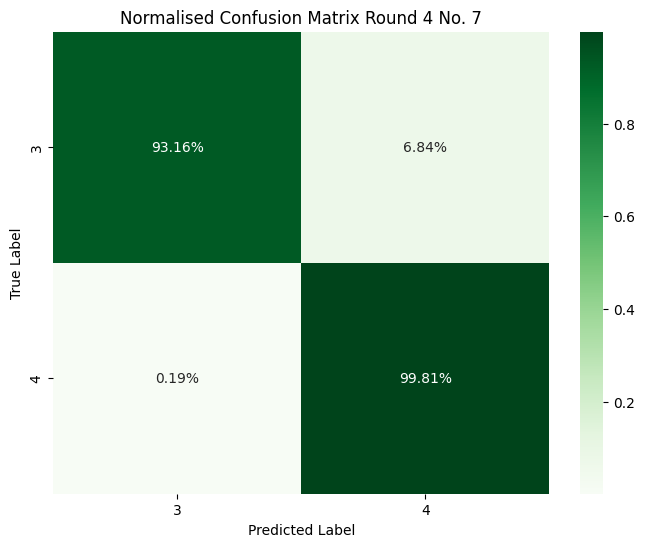

In [18]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming predictions, y_test are already defined

# Compute the normalized confusion matrix
cm_normalized = confusion_matrix(y_test, predictions, labels=[3, 4], normalize='true')

# Visualize the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Greens", xticklabels=[3, 4], yticklabels=[3, 4])
plt.title('Normalised Confusion Matrix Round 4 No. 7')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Feature permutation importance

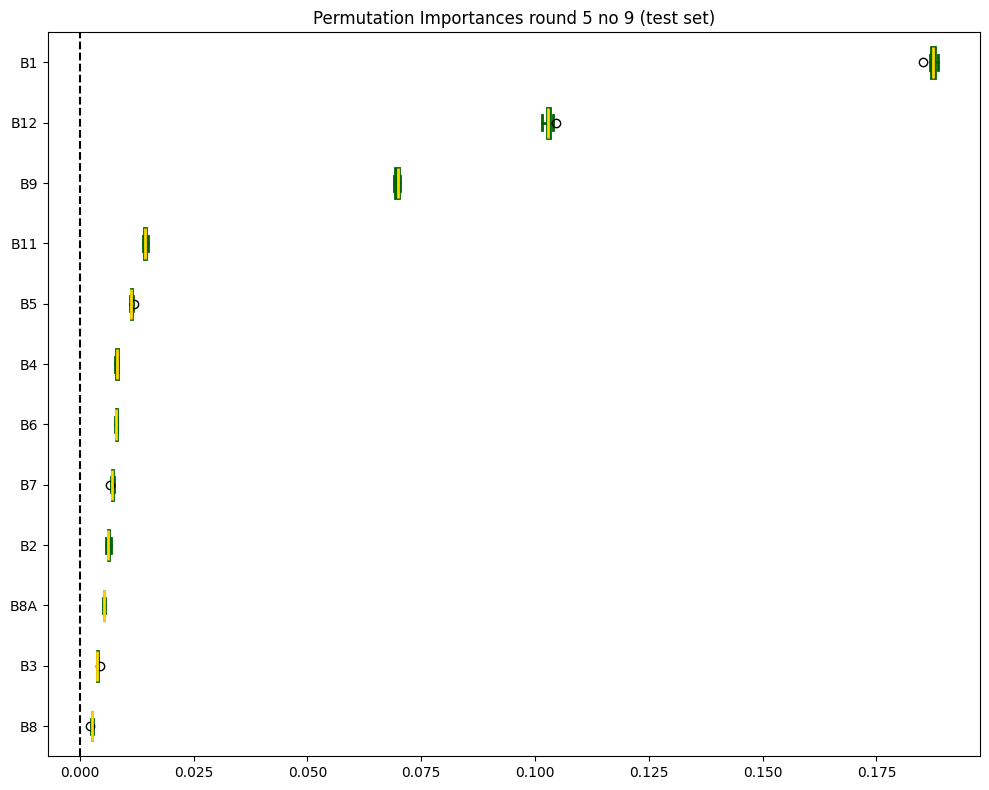

In [19]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Assuming clf is your trained RandomForestClassifier model
# and X_test, y_test are your test datasets

result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Sorting features by importance
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 8))
bp = ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx],
                patch_artist=True,  # To fill with color
                )

# Customizing the boxplot color to dark green
for box in bp['boxes']:
    # Change box color
    box.set(color='darkgreen', linewidth=2)  # Box edge color
    box.set(facecolor='darkgreen')  # Box fill color

# Optionally, customize whiskers, fliers, caps, and medians if needed
for whisker in bp['whiskers']:
    whisker.set(color='darkgreen', linewidth=2)
for cap in bp['caps']:
    cap.set(color='darkgreen', linewidth=2)
for median in bp['medians']:
    median.set(color='gold', linewidth=2)  # Making the median stand out

ax.axvline(x=0, color="k", linestyle="--")
ax.set_title("Permutation Importances round 5 no 9 (test set)")
plt.tight_layout()
plt.show()